In [ ]:
# Code by Irfan Bin Islam and Dr. Ghazanfar Latif / CAI@PMU
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
print("All needed packages imported successfully!")

All needed packages imported successfully!


In [19]:
#Define the data directory based on Google Drive

# Mount Google Drive

# Need to change based on the your Google Drive  DataSet Path
data_dir = r'C:\Samples\Short'


# You have to change based on the your dataset folder names.
classes= ['Silk', 'Cotton', 'Polyester']

In [20]:
import os
from glob import glob
images = glob(os.path.join(data_dir, '*/*.'))
tot_images = len(images)
print('Total images:', tot_images)

# import cv2
# img1 = cv2.resize(img1, (224, 224))

Total images: 0


In [21]:
im_cnt = []
class_names = []
print('{:18s}'.format('Class'), end='')
print('Count')
print('-' * 24)
for folder in os.listdir(os.path.join(data_dir)):
    folder_num = len(os.listdir(os.path.join(data_dir, folder)))
    im_cnt.append(folder_num)
    class_names.append(folder)
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)
    if (folder_num < tot_images):
        tot_images = folder_num
        folder_num = folder

num_classes = len(class_names)
print('Total number of classes: {}'.format(num_classes))



Class             Count
------------------------
Cotton               425
Polyester            400
Silk                 510
Total number of classes: 3


In [22]:
from torch.utils.data import Subset, DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import numpy as np

# Data transforms
data_transforms = {
    "train_transforms": transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "valid_transforms": transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test_transforms": transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Load the entire dataset without transforms initially
dataset = datasets.ImageFolder(data_dir, transform=None)  # Initially without any transforms

# Obtain dataset size and indices
num_total = len(dataset)
indices = list(range(num_total))
np.random.seed(42)  # Set random seed for reproducibility
np.random.shuffle(indices)

# Calculate split sizes
train_count = int(0.8 * num_total)
valid_count = int(0.1 * num_total)
test_count = num_total - train_count - valid_count

# Create data indices for training, validation, and testing
train_idx = indices[:train_count]
valid_idx = indices[train_count:train_count + valid_count]
test_idx = indices[train_count + valid_count:]

# Create subsets first, before applying the transforms
train_data = Subset(dataset, train_idx)
valid_data = Subset(dataset, valid_idx)
test_data = Subset(dataset, test_idx)

# Apply transforms to the datasets
train_data.dataset.transform = data_transforms["train_transforms"]
valid_data.dataset.transform = data_transforms["valid_transforms"]
test_data.dataset.transform = data_transforms["test_transforms"]

# Debugging outputs for subset sizes and sample indices
print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(valid_data)}")
print(f"Test samples: {len(test_data)}")

# Initialize DataLoaders without any sampler first for debugging
trainloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=16, shuffle=False)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)



Training samples: 1068
Validation samples: 133
Test samples: 134


In [23]:
# Define a custom sampler for the dataset loader avoiding recreating the dataset (just creating a new loader for each different sampling)
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [24]:
# Define the dataloaders using the image datasets. Dataloader is used to load our data in batches
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 16, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 16, sampler = valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 16, sampler = test_sampler)

In [25]:
#helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    plt.imshow(np.transpose(img, (1,2,0))) #convert tensor image type to numpy image type for visualization

In [26]:
# Specify model architecture
# Load the pretrained model from pytorch's library and stored it in model_transfer
#model_transfer = models.googlenet(pretrained=True)
#model_transfer = models.vgg16(pretrained=True)
model_transfer = models.inception_v3(pretrained=True)
# Check if GPU is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_transfer = model_transfer.cuda()

In [27]:
#print the model to see all the layers
print(model_transfer)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [28]:
#Lets read the fully connected layer
print(model_transfer.fc.in_features)
print(model_transfer.fc.out_features)

2048
1000


In [29]:
for param in model_transfer.parameters():
    param.requires_grad=True

In [30]:
# Define n_inputs takes the same number of inputs from pre-trained model
n_inputs = model_transfer.fc.in_features #refer to the fully connected layer only

# Add last linear layer (n_inputs -> 4 classes). In this case the ouput is 4 classes
# New layer automatically has requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

model_transfer.fc = last_layer

# If GPU is available, move the model to GPU
if use_cuda:
    model_transfer = model_transfer.cuda()

# Check to see the last layer produces the expected number of outputs
print(model_transfer.fc.out_features)

3


In [31]:
# Specify loss function and optimizer
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Print the sizes of your subsets
print(f"Train subset size: {len(train_data)}")
print(f"Valid subset size: {len(valid_data)}")
print(f"Test subset size: {len(test_data)}")

# Ensure the indices are valid
print(f"First 10 train indices: {train_idx[:10]}")
print(f"First 10 valid indices: {valid_idx[:10]}")
print(f"First 10 test indices: {test_idx[:10]}")



Train subset size: 1068
Valid subset size: 133
Test subset size: 134
First 10 train indices: [898, 1062, 1253, 298, 237, 481, 240, 277, 415, 705]
First 10 valid indices: [517, 476, 157, 16, 1072, 546, 658, 1097, 1019, 1121]
First 10 test indices: [1236, 484, 95, 1020, 563, 742, 863, 891, 1038, 206]


In [ ]:

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    '''returns trained model'''
    # Initialize tracker for minimum validation loss
    valid_loss_min = np.inf

    for epoch in range(1, n_epochs+1):
        # Initialize variables to track training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        # Model training
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # Move to GPU if available
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # Clear the gradients from the previous step
            optimizer.zero_grad()

            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # If model returns an InceptionOutputs object, extract the logits
            if isinstance(output, tuple):
                output = output[0]  # Get the main logits output (the first element)

            # Calculate the loss
            loss = criterion(output, target)

            # Backward pass: compute gradients of the loss with respect to model parameters
            loss.backward()

            # Perform optimization step (update the model parameters)
            optimizer.step()

            # Update the training loss
            train_loss += loss.item()

        # Model validation
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # Move to GPU if available
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # If model returns an InceptionOutputs object, extract the logits
            if isinstance(output, tuple):
                output = output[0]  # Get the main logits output (the first element)

            # Calculate the loss
            loss = criterion(output, target)

            # Update the validation loss
            valid_loss += loss.item()

        # Average the losses over the batches
        train_loss /= len(loaders['train'])
        valid_loss /= len(loaders['valid'])

        # Print training/validation stats
        print(f'Epoch {epoch}/{n_epochs} | '
              f'Training Loss: {train_loss:.4f} | '
              f'Validation Loss: {valid_loss:.4f}')

        # Save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.4f} --> {valid_loss:.4f}). Saving model...')
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    return model

loaders_transfer = {'train': trainloader, 'valid': validloader, 'test': testloader}

# Train the model
model_transfer = train(n_epochs=20, 
                       loaders=loaders_transfer, 
                       model=model_transfer, 
                       optimizer=optimizer_transfer, 
                       criterion=criterion_transfer, 
                       use_cuda=use_cuda, 
                       save_path=r'C:\Coding\incep.pt')

In [ ]:
model_transfer.load_state_dict(torch.load('incep.pt'))


C:\Users\patwe\AppData\Local\Temp\ipykernel_7672\721543319.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_transfer.load_state_dict(torch.load('model_transfer.pt')

<All keys matched successfully>

In [ ]:
def test(loaders, model, criterion, use_cuda):
    # Initialize variables to monitor test loss and accuracy
    test_loss = 0.0
    correct = 0
    total = 0

    model.eval()  # Set model to evaluation mode (disable dropout, batchnorm updates)

    # Iterate over test data
    with torch.no_grad():  # Disable gradient computation for efficiency
        for batch_idx, (data, target) in enumerate(loaders['test']):
            # Move data and target to GPU if available
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)  # Directly get the logits; no need for auxiliary outputs

            # Calculate the loss
            loss = criterion(output, target)

            # Update the cumulative test loss
            test_loss += loss.item()  # Sum the losses for averaging later

            # Get the predicted class by finding the index of the max logit
            pred = output.argmax(1, keepdim=True)  # Index of the max logit

            # Compare predictions to true labels
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += data.size(0)

    # Calculate average test loss
    test_loss /= len(loaders['test'])  # Average test loss over all batches

    # Print test loss and accuracy
    print(f'Test Loss: {test_loss:.6f}')
    print(f'Test Accuracy: {100. * correct / total:.2f}% ({correct}/{total})')

# Call the test function
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.000949
Test Accuracy: 100.00% (134/134)


Test Loss: 0.000949
Test Accuracy: 100.00% (134/134)
Unique values in targets: [0 1 2]
Unique values in predictions: [0 1 2]

Confusion Matrix:
 [[44  0  0]
 [ 0 40  0]
 [ 0  0 50]]


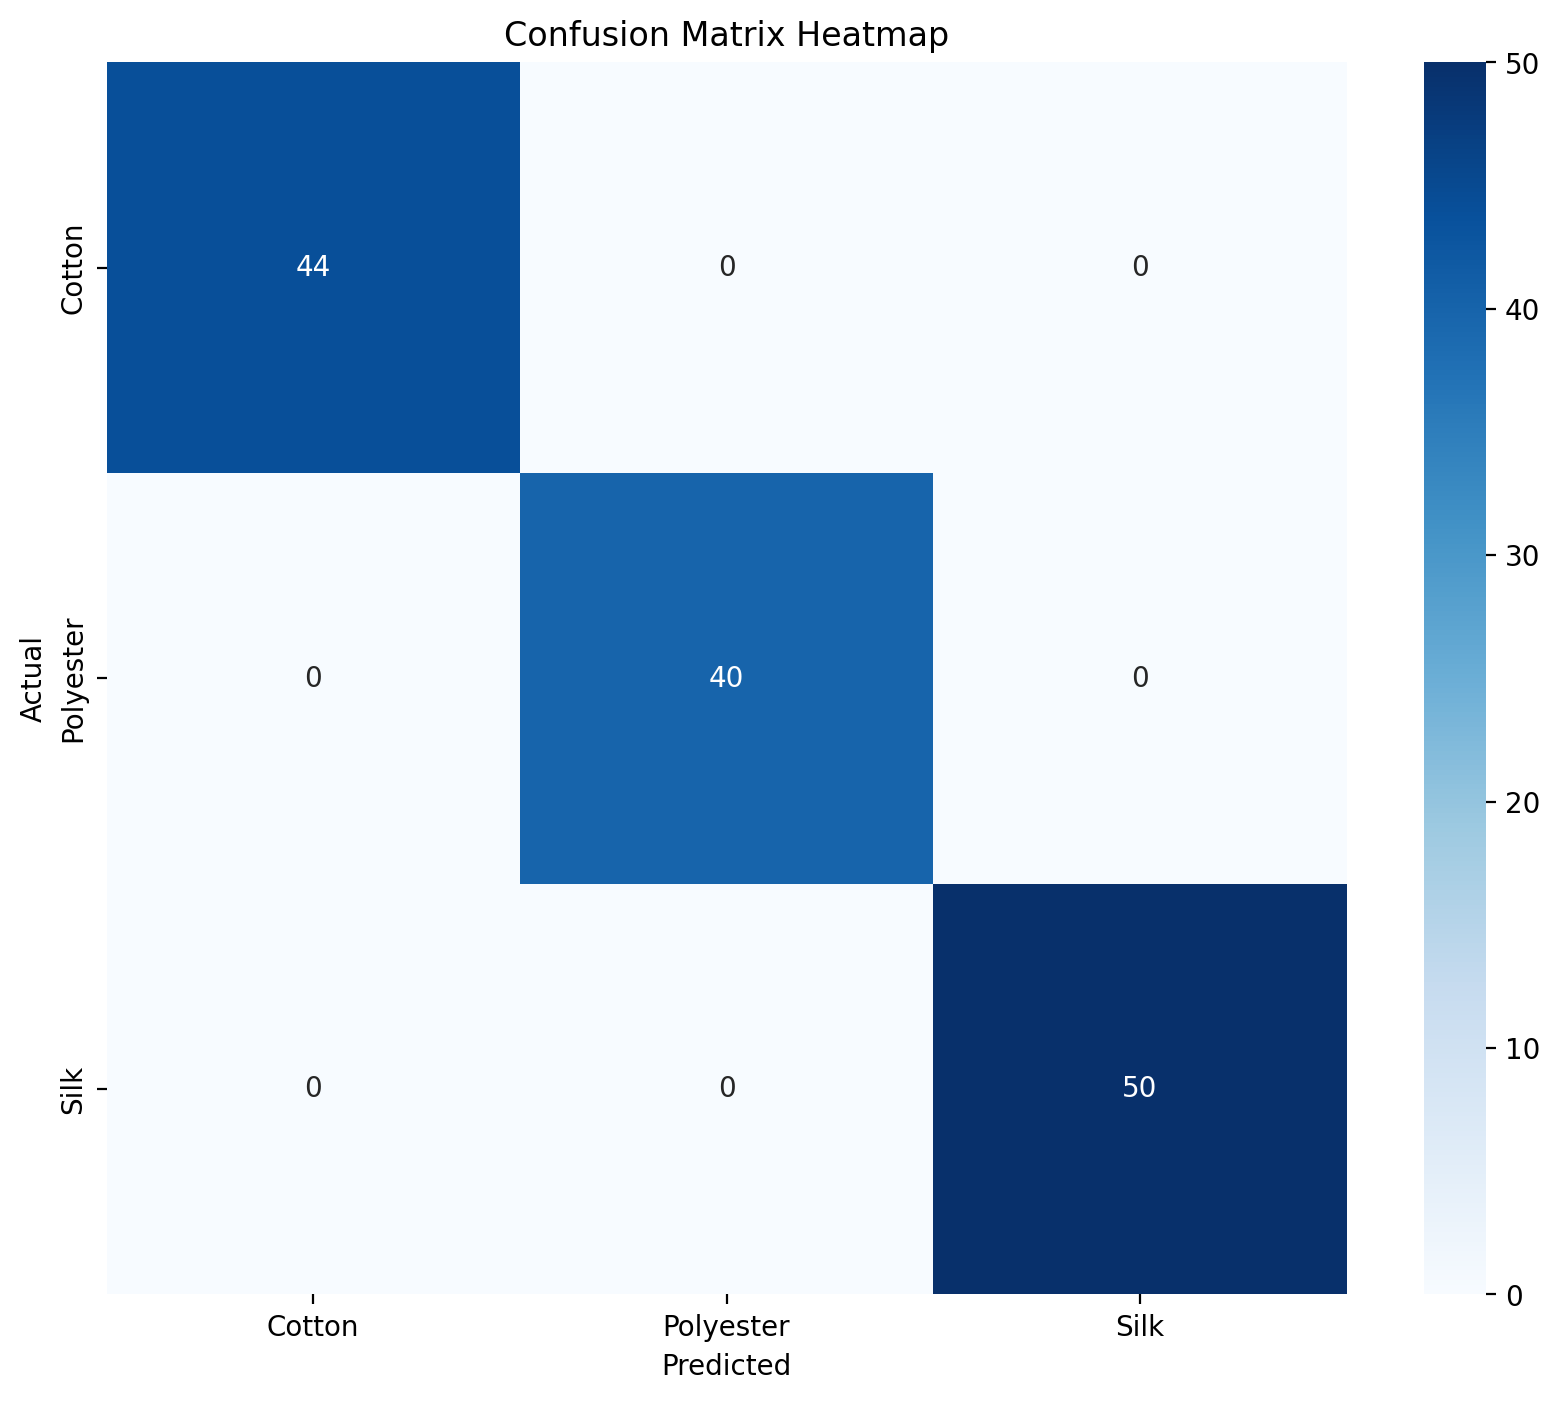


Classification Report:
               precision    recall  f1-score   support

      Cotton       1.00      1.00      1.00        44
   Polyester       1.00      1.00      1.00        40
        Silk       1.00      1.00      1.00        50

    accuracy                           1.00       134
   macro avg       1.00      1.00      1.00       134
weighted avg       1.00      1.00      1.00       134



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def test(loaders, model, criterion, use_cuda, class_names):
    # Initialize variables to monitor test loss and accuracy
    test_loss = 0.0
    correct = 0
    total = 0

    all_preds = []  # To store all predictions
    all_targets = []  # To store all true labels

    model.eval()  # Set model to evaluation mode (disable dropout, batchnorm updates)
    
    # Iterate over test data
    with torch.no_grad():  # Disable gradient computation for efficiency
        for batch_idx, (data, target) in enumerate(loaders['test']):
            # Move data and target to GPU if available
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)  # Directly get the logits; no auxiliary outputs

            # Calculate the loss
            loss = criterion(output, target)

            # Update the cumulative test loss
            test_loss += loss.item()  # Sum the losses for averaging later

            # Get the predicted class by finding the index of the max logit
            pred = output.argmax(1, keepdim=False)  # Index of the max logit

            # Store predictions and true labels
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

            # Compare predictions to true labels
            correct += pred.eq(target).sum().item()
            total += data.size(0)

    # Calculate average test loss
    test_loss /= len(loaders['test'])  # Average test loss over all batches

    # Print test loss and accuracy
    print(f'Test Loss: {test_loss:.6f}')
    print(f'Test Accuracy: {100. * correct / total:.2f}% ({correct}/{total})')

    # Debug: Print unique classes
    print("Unique values in targets:", np.unique(all_targets))
    print("Unique values in predictions:", np.unique(all_preds))

    # Generate confusion matrix
    labels = range(len(class_names))  # Ensure all class indices are included
    cm = confusion_matrix(all_targets, all_preds, labels=labels)
    print("\nConfusion Matrix:\n", cm)

    # Plot confusion matrix heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

    # Print classification report
    report = classification_report(all_targets, all_preds, target_names=class_names, labels=labels)
    print("\nClassification Report:\n", report)

# Example usage:
class_names = ["Cotton", "Polyester", "Silk"]  # Replace with your class names
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda, class_names)